
- [Base model](https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn/notebook)

### **Importing Data from Google Drive**

In [4]:
import pandas as pd

#This mounts your drive so that you can access files from it in colab. It's not clear to me yet
#whether this needs to be done multiple times for each user. If it does, 
#it will prompt you for your google authentication when you run this cell. -L

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#basically, just click on the link, let it use your google account, and then copy/paste in the link it gives you
#it seems to need setup once the runtime is suspended.

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
#before running this, you're going to want to right click on the group folder, then add it to your drive.
%cd /content/drive/My\ Drive/Powerpuff\ Girls

/content/drive/My Drive/Powerpuff Girls


In [6]:
#!pip install python-snappy
#!pip install pyarrow 

train_0 = pd.read_parquet('bengaliai_cv19/train_image_data_0.parquet', engine='pyarrow')
#Running this on my computer successfully loads the first train image file. -L
train_0.head()


,image_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,32292,32293,32294,32295,32296,32297,32298,32299,32300,32301,32302,32303,32304,32305,32306,32307,32308,32309,32310,32311,32312,32313,32314,32315,32316,32317,32318,32319,32320,32321,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,253,254,253,253,253,254,253,252,253,253,253,253,252,252,253,253,252,252,253,252,252,252,253,254,253,253,252,252,252,253,...,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,252,250,250,246,249,248,250,249,251,252,253,253,253,253,253,253,253,250,249,251,252,251,251,251,251,252,253,251,250,252,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,252,253,252,252,251,250,251,253,254,251,251,252,252,253,253,252,251,251,249,251,252,252,253,252,251,251,251,250,250,252,...,253,253,252,252,252,253,253,253,253,253,252,251,251,250,250,250,251,251,251,250,250,250,251,252,253,253,253,253,254,254,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,250,251,250,249,251,251,251,250,252,251,245,245,251,252,251,252,252,250,249,250,251,250,249,250,251,252,253,252,252,252,...,253,252,252,254,253,253,254,253,252,253,254,253,252,253,254,254,254,254,254,254,254,254,253,252,253,254,253,252,253,254,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,225,231,229,229,228,221,224,226,221,221,220,217,217,218,219,222,224,214,218,227,227,227,228,224,231,235,235,233,212,183,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255


In [0]:
def import_data(s, folder = 'bengaliai_cv19'):
  '''
  Imports data from the bengaliai_cv9 folder, assuming the drive has been mounted correctly in colab
  s: a string, either "train" or "test" which decides the data to be input
  folder: a string. assumes the 'bengaliai_cv19' folder
  '''
  #I think this should *technically* work, but I'm having some issues with memory.
  #I'm thinking maybe the labels alone can be imported instead, and the image data can be accessed with generators. -L
  #Basically, you can go ahead and ignore this one.
  data_dir_base = folder + '/' + s.lower() + '_image_data_'
  label_dir = folder + '/' + s.lower() + '.csv'
  data = []
  #get image data from 4 files
  for i in range(4):
    data.append(pd.read_parquet(data_dir_base + str(i) + '.parquet', engine = 'pyarrow'))
  #vertically concatenate image data
  data = pd.concat(data)
  #get labels
  labels = pd.read_csv(label_dir)
  #join dataframes by image_id column
  data = data.join(labels, on = 'image_id')
  return data


In [0]:
#!pip install tensorflow==1.14.0

In [9]:
#beginner kaggle base model begins here

%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2

import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

!rm -rf ./logs/ 

1.15.0


Using TensorFlow backend.


In [10]:
tf.__version__ #MUST BE VERSION 1.14.0!!!

'1.15.0'

In [0]:
train_df_ = pd.read_csv('bengaliai_cv19/train.csv')
test_df_ = pd.read_csv('bengaliai_cv19/test.csv')
class_map_df = pd.read_csv('bengaliai_cv19/class_map.csv')
sample_sub_df = pd.read_csv('bengaliai_cv19/sample_submission.csv')

In [12]:
train_df_.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [13]:
test_df_.head()

,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root


In [14]:
sample_sub_df.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,0
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,0


In [15]:
class_map_df.head()

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


In [16]:
print(f'Size of training data: {train_df_.shape}')
print(f'Size of test data: {test_df_.shape}')
print(f'Size of class map: {class_map_df.shape}')

Size of training data: (200840, 5)
Size of test data: (36, 3)
Size of class map: (186, 3)


### **Exploratory Data Analysis**

In [0]:
HEIGHT = 236
WIDTH = 236

def get_n(df, field, n, top=True):
    top_graphemes = df.groupby([field]).size().reset_index(name='counts')['counts'].sort_values(ascending=not top)[:n]
    top_grapheme_roots = top_graphemes.index
    top_grapheme_counts = top_graphemes.values
    top_graphemes = class_map_df[class_map_df['component_type'] == field].reset_index().iloc[top_grapheme_roots]
    top_graphemes.drop(['component_type', 'label'], axis=1, inplace=True)
    top_graphemes.loc[:, 'count'] = top_grapheme_counts
    return top_graphemes

def image_from_char(char):
    image = Image.new('RGB', (WIDTH, HEIGHT))
    draw = ImageDraw.Draw(image)
    myfont = ImageFont.truetype('kalpurush-2.ttf', 120)
    w, h = draw.textsize(char, font=myfont)
    draw.text(((WIDTH - w) / 2,(HEIGHT - h) / 3), char, font=myfont)

    return image

In [18]:
print(f'Number of unique grapheme roots: {train_df_["grapheme_root"].nunique()}')
print(f'Number of unique vowel diacritic: {train_df_["vowel_diacritic"].nunique()}')
print(f'Number of unique consonant diacritic: {train_df_["consonant_diacritic"].nunique()}')

Number of unique grapheme roots: 168
Number of unique vowel diacritic: 11
Number of unique consonant diacritic: 7


In [19]:
top_10_roots = get_n(train_df_, 'grapheme_root', 10)
top_10_roots
#top_10_roots.to_latex('top_10_roots')

,index,component,count
72,72,দ,5736
64,64,ত,5596
13,13,ক,5420
107,107,ব,5321
23,23,গ,5149
96,96,প,4926
113,113,ভ,4395
147,147,স,4392
133,133,শ,4374
115,115,ম,4015


### Most used top 10 Grapheme Roots in training set

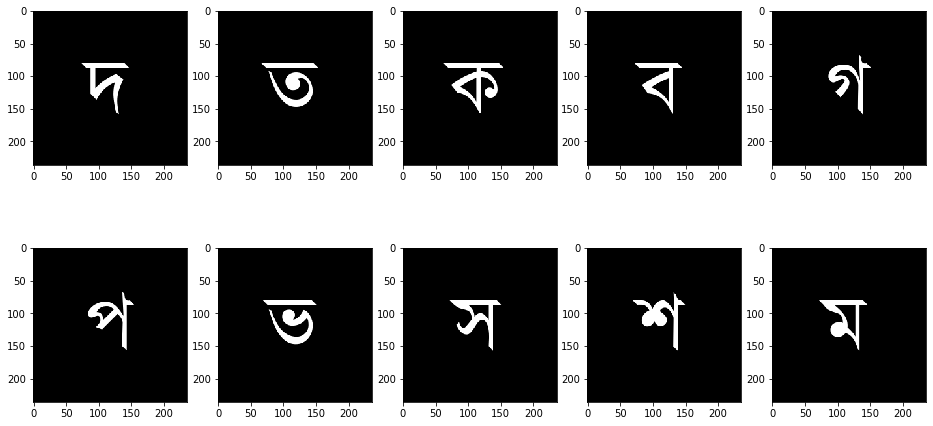

In [20]:
f, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(10):
    ax[i].imshow(image_from_char(top_10_roots['component'].iloc[i]), cmap='Greys')

### Least used 10 Grapheme Roots in training set

In [0]:
bottom_10_roots = get_n(train_df_, 'grapheme_root', 10, False)
#bottom_10_roots.to_latex('bottom_10_roots')

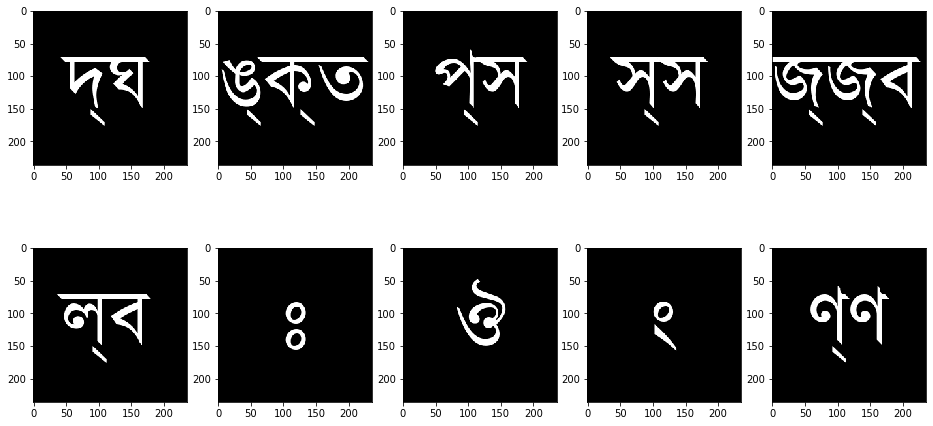

In [22]:
f, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(10):
    ax[i].imshow(image_from_char(bottom_10_roots['component'].iloc[i]), cmap='Greys')

### Top 5 Vowel Diacritic in training data

In [0]:
top_5_vowels = get_n(train_df_, 'vowel_diacritic', 5)
#top_5_vowels.to_latex('top_5_vowels')


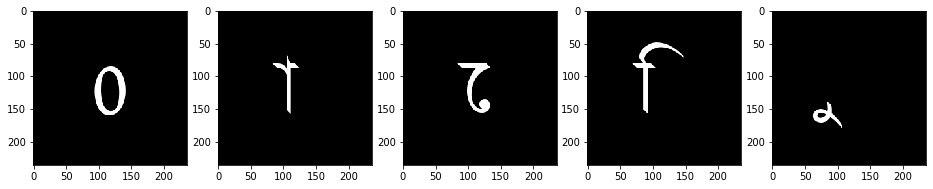

In [24]:
f, ax = plt.subplots(1, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(5):
    ax[i].imshow(image_from_char(top_5_vowels['component'].iloc[i]), cmap='Greys')

### Top 5 Consonant Diacritic in training data

In [0]:
top_5_consonants = get_n(train_df_, 'consonant_diacritic', 5)
#top_5_consonants.to_latex("top_5_consonants")

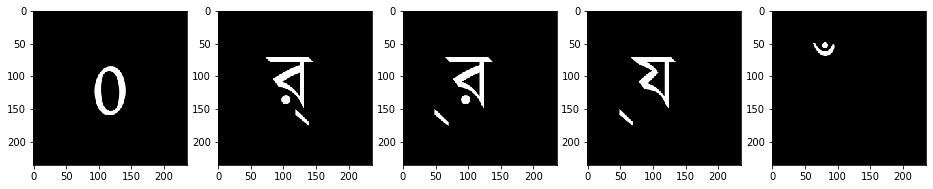

In [26]:
f, ax = plt.subplots(1, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(5):
    ax[i].imshow(image_from_char(top_5_consonants['component'].iloc[i]), cmap='Greys')

In [0]:
train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)

In [0]:
train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

Let's apply some image processing (credits: [this kernel](https://www.kaggle.com/shawon10/bangla-graphemes-image-processing-deep-cnn)) while resizing the images, which will center crop the region of interest from the original images.

In [0]:
IMG_SIZE=64 #64 pixel square
N_CHANNELS=1 #1 channel means grayscale image

In [0]:
def resize(df, size=64, need_progress_bar=True):
    resized = {}
    resize_size=64
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            #print(np.shape(df.loc[df.index[i]].values))
            image=df.loc[df.index[i]].values.reshape(137,236)
            image = np.uint8(image) # add this line to ensure image file is in the right format for threshold function below
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    else:
        for i in range(df.shape[0]):
            #image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size),None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
            image=df.loc[df.index[i]].values.reshape(137,236)
            image = np.uint8(image) # add this line to ensure image file is in the right format for threshold function below
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized

In [0]:
#helper function for classifying at the end of the model

def get_dummies(df):
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

###**Basic** **Model**

In [32]:
inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
#model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

#model = Flatten()(model)
model = GlobalAveragePooling2D(data_format='channels_last')(model) #global average pooling replaces flatten()
model = Dense(1024, activation = "relu")(model)
model = Dropout(rate=0.3)(model)
dense = Dense(512, activation = "relu")(model)

head_root = Dense(168, activation = 'softmax')(dense)
head_vowel = Dense(11, activation = 'softmax')(dense)
head_consonant = Dense(7, activation = 'softmax')(dense)

model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_2[0][0]                   
____________________________________________________________________________________________

Let's visualize the 3-tailed (3 output) CNN by plotting it.

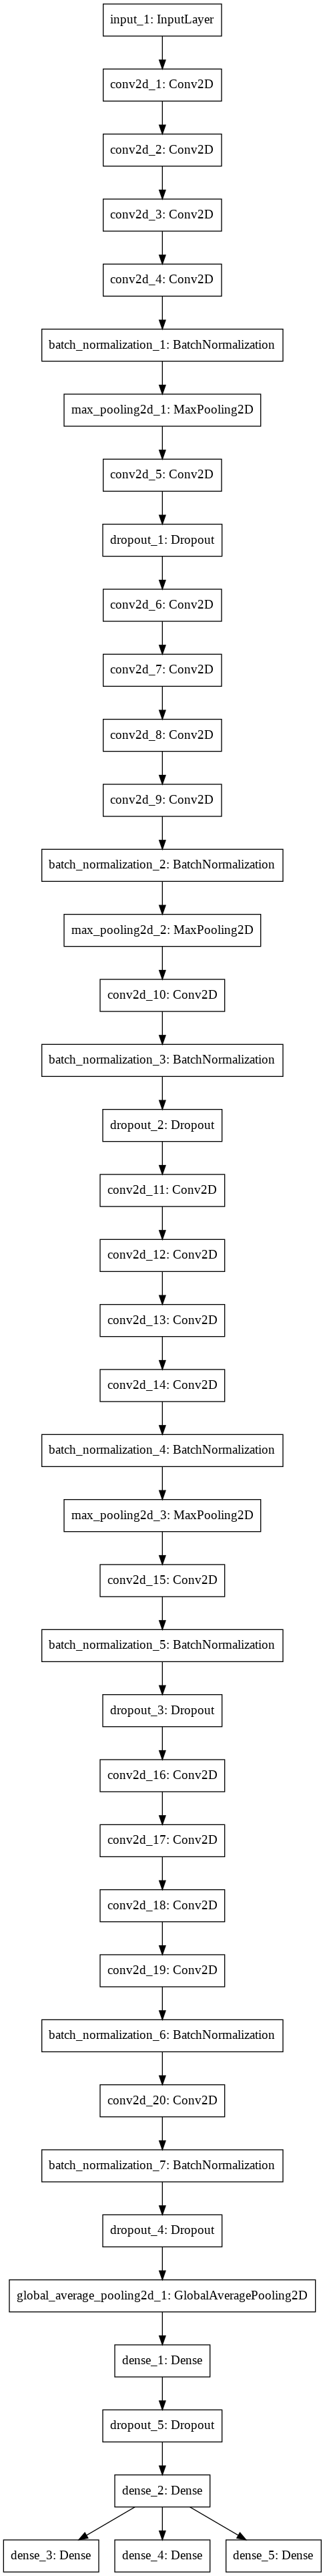

In [34]:
from keras.utils import plot_model
plot_model(model, to_file='final_model.png')

In [35]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
learning_rate_reduction_root = ReduceLROnPlateau(monitor='val_dense_3_acc', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='val_dense_4_acc', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='val_dense_5_acc', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
batch_size = 256
epochs = 15

In [0]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

### **Training Loop**

In [0]:
HEIGHT = 137
WIDTH = 236

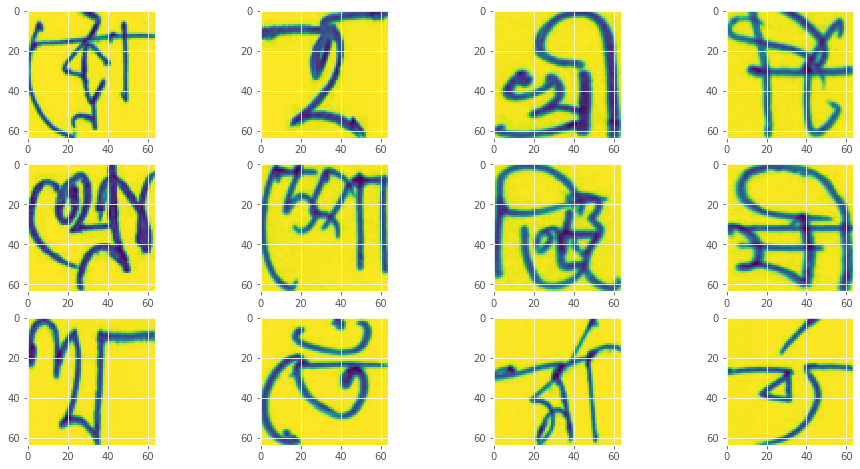


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/15
180/180 [==============================] - 102s 569ms/step - loss: 0.4369 - dense_3_loss: 0.2318 - dense_4_loss: 0.1199 - dense_5_loss: 0.0851 - dense_3_acc: 0.9300 - dense_4_acc: 0.9642 - dense_5_acc: 0.9730 - val_loss: 0.3269 - val_dense_3_loss: 0.2011 - val_dense_4_loss: 0.0643 - val_dense_5_loss: 0.0615 - val_dense_3_acc: 0.9422 - val_dense_4_acc: 0.9846 - val_dense_5_acc: 0.9816
Epoch 2/15
180/180 [==============================] - 102s 564ms/step - loss: 0.4264 - dense_3_loss: 0.2263 - dense_4_loss: 0.1166 - dense_5_loss: 0.0834 - dense_3_acc: 0.9331 - dense_4_acc: 0.9655 - dense_5_acc: 0.9741 - val_loss: 0.3057 - val_dense_3_loss: 0.1919 - val_dense_4_loss: 0.0593 - val_dense_5_loss: 0.0546 - val_dense_3_acc: 0.9430 - val_dense_4_acc: 0.9848 - val_dense_5_acc: 0.9846
Epoch 3/15
180/180 [==============================] - 102s

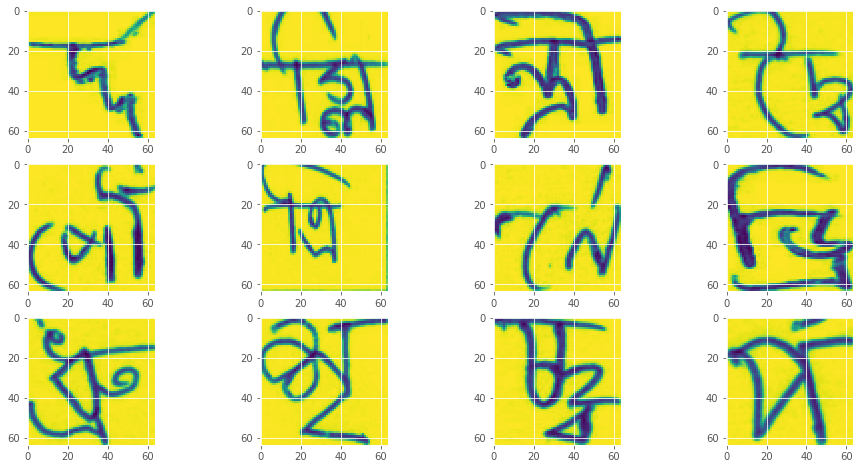


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/15
180/180 [==============================] - 102s 569ms/step - loss: 0.3867 - dense_3_loss: 0.2012 - dense_4_loss: 0.1053 - dense_5_loss: 0.0802 - dense_3_acc: 0.9380 - dense_4_acc: 0.9684 - dense_5_acc: 0.9756 - val_loss: 0.3306 - val_dense_3_loss: 0.1926 - val_dense_4_loss: 0.0789 - val_dense_5_loss: 0.0592 - val_dense_3_acc: 0.9472 - val_dense_4_acc: 0.9773 - val_dense_5_acc: 0.9853
Epoch 2/15
180/180 [==============================] - 101s 564ms/step - loss: 0.3864 - dense_3_loss: 0.1995 - dense_4_loss: 0.1082 - dense_5_loss: 0.0787 - dense_3_acc: 0.9395 - dense_4_acc: 0.9672 - dense_5_acc: 0.9759 - val_loss: 0.3207 - val_dense_3_loss: 0.1901 - val_dense_4_loss: 0.0719 - val_dense_5_loss: 0.0587 - val_dense_3_acc: 0.9462 - val_dense_4_acc: 0.9788 - val_dense_5_acc: 0.9851
Epoch 3/15
180/180 [==============================] - 101s

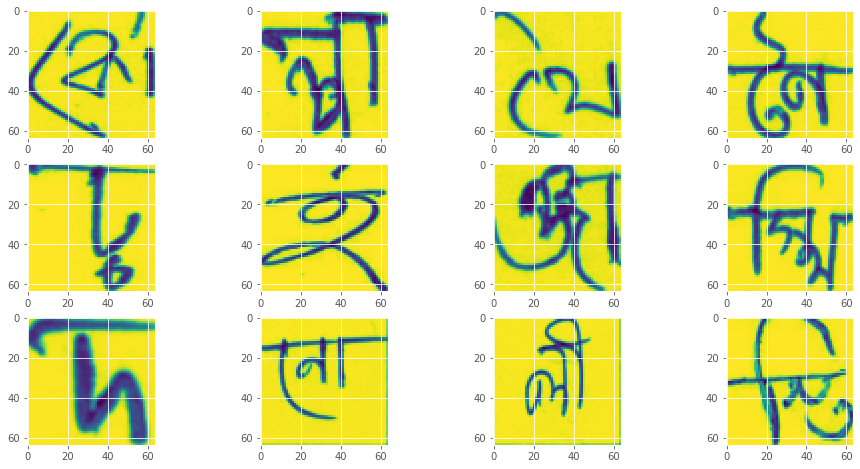


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/15
180/180 [==============================] - 103s 570ms/step - loss: 0.5006 - dense_3_loss: 0.2796 - dense_4_loss: 0.1238 - dense_5_loss: 0.0971 - dense_3_acc: 0.9178 - dense_4_acc: 0.9625 - dense_5_acc: 0.9698 - val_loss: 0.3269 - val_dense_3_loss: 0.1995 - val_dense_4_loss: 0.0645 - val_dense_5_loss: 0.0628 - val_dense_3_acc: 0.9467 - val_dense_4_acc: 0.9816 - val_dense_5_acc: 0.9816
Epoch 2/15
180/180 [==============================] - 102s 564ms/step - loss: 0.4980 - dense_3_loss: 0.2769 - dense_4_loss: 0.1262 - dense_5_loss: 0.0950 - dense_3_acc: 0.9196 - dense_4_acc: 0.9629 - dense_5_acc: 0.9706 - val_loss: 0.3424 - val_dense_3_loss: 0.2053 - val_dense_4_loss: 0.0694 - val_dense_5_loss: 0.0677 - val_dense_3_acc: 0.9462 - val_dense_4_acc: 0.9808 - val_dense_5_acc: 0.9811
Epoch 3/15
180/180 [==============================] - 102s

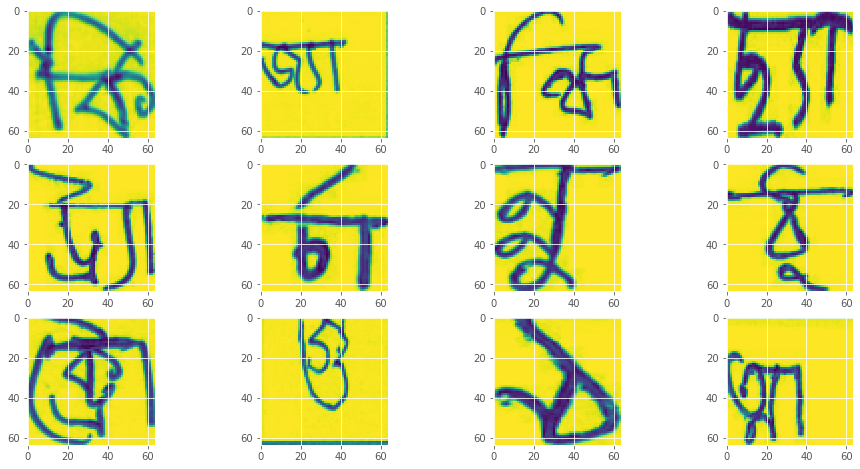


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/15
180/180 [==============================] - 102s 569ms/step - loss: 0.4963 - dense_3_loss: 0.2773 - dense_4_loss: 0.1273 - dense_5_loss: 0.0918 - dense_3_acc: 0.9204 - dense_4_acc: 0.9621 - dense_5_acc: 0.9715 - val_loss: 0.3198 - val_dense_3_loss: 0.1892 - val_dense_4_loss: 0.0808 - val_dense_5_loss: 0.0498 - val_dense_3_acc: 0.9417 - val_dense_4_acc: 0.9811 - val_dense_5_acc: 0.9856
Epoch 2/15
180/180 [==============================] - 101s 564ms/step - loss: 0.4933 - dense_3_loss: 0.2736 - dense_4_loss: 0.1267 - dense_5_loss: 0.0930 - dense_3_acc: 0.9199 - dense_4_acc: 0.9629 - dense_5_acc: 0.9714 - val_loss: 0.3307 - val_dense_3_loss: 0.1926 - val_dense_4_loss: 0.0851 - val_dense_5_loss: 0.0530 - val_dense_3_acc: 0.9440 - val_dense_4_acc: 0.9778 - val_dense_5_acc: 0.9861
Epoch 3/15
180/180 [==============================] - 101s

In [47]:
histories = []
#file_nums = [5] #added to test a subset of files
for i in range(2): 
#for i in file_nums: #to test the specific files instead

    #merge with dataframe that has the outcomes in it
    train_df = pd.merge(pd.read_parquet(f'bengaliai_cv19/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)
    #print(train_df.head())
    # Visualize few samples of current training dataset
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
    count=0
    for row in ax:
        for col in row:
            col.imshow(resize(train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], need_progress_bar=False).values.reshape(-1).reshape(IMG_SIZE, IMG_SIZE).astype(np.float64))
            count += 1
    plt.show()
    
    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train)/255
    
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')

    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)

    # Fit the model
    history = model.fit_generator(datagen.flow(x_train, {'dense_3': y_train_root, 'dense_4': y_train_vowel, 'dense_5': y_train_consonant}, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                              steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel, learning_rate_reduction_consonant])

    log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    histories.append(history)
    
    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()

In [0]:
%matplotlib inline
def plot_loss(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_3_loss'], label='train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_4_loss'], label='train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_5_loss'], label='train_consonant_loss')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_3_loss'], label='val_train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_4_loss'], label='val_train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_5_loss'], label='val_train_consonant_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    fig1 = plt.gcf()
    fig1.savefig('graphs/plot_loss_final_' + str(dataset) + '.png', dpi = 300)
    plt.show()


def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['dense_3_acc'], label='train_root_acc')
    plt.plot(np.arange(0, epoch), his.history['dense_4_acc'], label='train_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['dense_5_acc'], label='train_consonant_accuracy')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_3_acc'], label='val_root_acc')
    plt.plot(np.arange(0, epoch), his.history['val_dense_4_acc'], label='val_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['val_dense_5_acc'], label='val_consonant_accuracy')
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    fig1 = plt.gcf()
    fig1.savefig('graphs/plot_acc_final_' + str(dataset) + '.png', dpi = 300)
    plt.show()

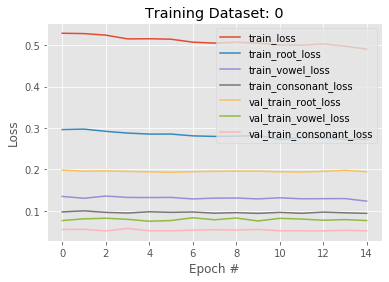

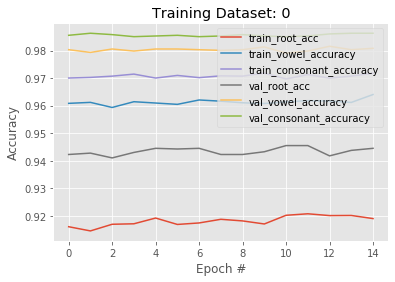

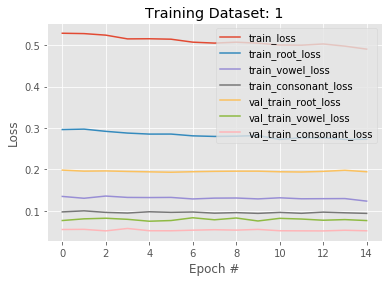

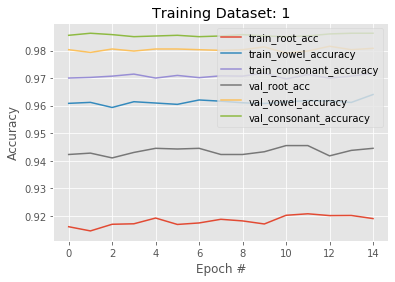

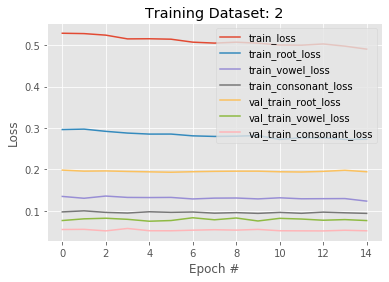

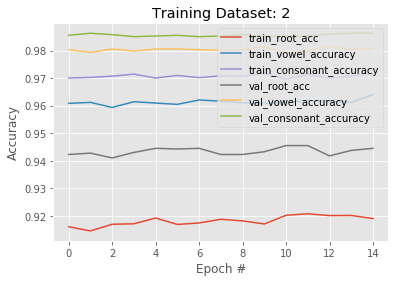

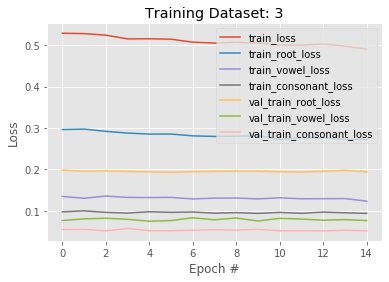

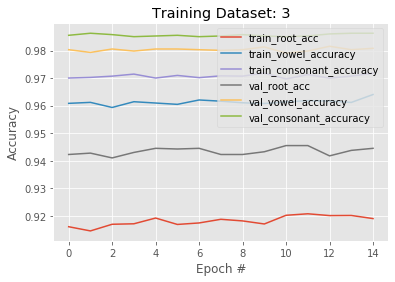

In [43]:
for dataset in range(4):
  plot_loss(history, epochs, f'Training Dataset: {dataset}')
  plot_acc(history, epochs, f'Training Dataset: {dataset}')

In [49]:
#del histories
gc.collect()

8

In [44]:
print(history.history['dense_3_acc'][14])
print(history.history['dense_4_acc'][14])
print(history.history['dense_5_acc'][14])

pd.DataFrame(history.history).to_csv('history.history.csv')

0.9189542198735458
0.9640377037663286
0.9717656790458905


In [0]:
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}

In [50]:
components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
target=[] # model predictions placeholder
row_id=[] # row_id place holder
for i in range(4):
    df_test_img = pd.read_parquet('bengaliai_cv19/test_image_data_{}.parquet'.format(i)) 
    df_test_img.set_index('image_id', inplace=True)

    X_test = resize(df_test_img, need_progress_bar=False)/255
    X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    preds = model.predict(X_test)

    for i, p in enumerate(preds_dict):
        preds_dict[p] = np.argmax(preds[i], axis=1)

    for k,id in enumerate(df_test_img.index.values):  
        for i,comp in enumerate(components):
            id_sample=id+'_'+comp
            row_id.append(id_sample)
            target.append(preds_dict[comp][k])
    del df_test_img
    #del X_test
    gc.collect()

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
df_sample.to_csv('final_submission.csv',index=False)
df_sample.head()

NameError: ignored

In [45]:
#Final Scores:

root_accuracy = history.history['dense_3_acc'][14]
vowel_accuracy = history.history['dense_4_acc'][14]
consanant_accuracy = history.history['dense_5_acc'][14]

print('root diacritic accuracy is: ' + str(root_accuracy))
print('vowel diacritic accuracy is: ' + str(vowel_accuracy))
print('consanant diacritic accuracy is: ' + str(consanant_accuracy))


root diacritic accuracy is: 0.9189542198735458
vowel diacritic accuracy is: 0.9640377037663286
consanant diacritic accuracy is: 0.9717656790458905


In [46]:
final_score = (root_accuracy*2 + vowel_accuracy + consanant_accuracy)/4

print('final score accuracy: ' + str(final_score))

final score accuracy: 0.9434279556398276


###**Image** **Processing**: 
NOTE: Does not need to be run, files are in the folder already! 

Augment our existing training data by adding noise, etc to the training set. From this kernel: https://www.kaggle.com/chekoduadarsh/bengali-ai-understand-and-augment-eda

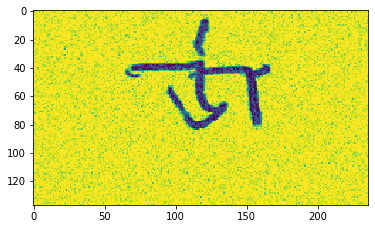

In [0]:
#from the source kernel:
import random


#adopt the source kernel's naming convention, to avoid making typos later
b_train_data = pd.read_parquet(f'bengaliai_cv19/train_image_data_0.parquet') #this is the same file we loaded in earlier

imageid = b_train_data.iloc[:, 0]
image = b_train_data.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH)
rand_num = random.randint(0,len(image))

#add gaussian noise to a random image
import skimage
img = image[rand_num]
img = skimage.util.random_noise(img, mode='gaussian', seed=None, clip=True)
plt.imshow(img)
plt.show() #show the image with added noise



In [0]:
import pandas as pd 

#my contribution: turn this into a function

def gaussian(filepath, subset): #inputs are a parquet file and a denominator for the fraction of the dataset to which the function is applied
  b_train_data = pd.read_parquet(filepath) 
  imageid = b_train_data.iloc[:, 0]
  image = b_train_data.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) #make a square image

  size = len(b_train_data) // subset #apply this filter to a subset of the dataframe so the session does not crash
  #create a random list of numbers from which to draw 
  random.seed(12) #set a seed so the same images chosen each time - for debugging
  indices = [np.random.choice(len(b_train_data), replace=False) for i in range(size)]
    #how can I ensure there's one of each outcome in the frame

  dictionary = dict() #make an empty dictionary

  for i in indices:
    img = image[i]
    img = skimage.util.random_noise(img, mode='gaussian', seed=None, clip=True) #add the noise
    img2 = img.flatten() #make images 1-d again
    dictionary['Train_'+str(i)]=img2
  
  dataframe = pd.DataFrame.from_dict(dictionary, orient='index')
  dataframe.transpose()
  dataframe.columns = dataframe.columns.astype(str)
  dataframe.insert(0, 'image_id', dataframe.index) #make a new image_id column to match other files
  dataframe = dataframe.reset_index() #add a different column of indices, to make it match
  dataframe = dataframe.drop(labels='index', axis=1) #drop superfluous index column

  return dataframe

df_gaussian = gaussian(f'bengaliai_cv19/train_image_data_0.parquet', 9)

df_gaussian.head()


,image_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,32292,32293,32294,32295,32296,32297,32298,32299,32300,32301,32302,32303,32304,32305,32306,32307,32308,32309,32310,32311,32312,32313,32314,32315,32316,32317,32318,32319,32320,32321,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_36093,0.904122,1.000000,0.772619,1.000000,1.000000,0.982886,0.949852,0.901949,1.000000,1.000000,0.681860,1.000000,0.947792,0.953803,0.899046,1.000000,0.980282,1.000000,1.000000,0.916309,0.728778,0.898462,0.812672,0.954336,0.955449,0.934516,0.892227,1.000000,1.000000,1.000000,1.000000,0.94476,0.87837,1.000000,0.793380,1.0,0.845965,0.961039,0.956615,...,0.863498,0.834167,0.997578,0.959412,0.920306,0.894553,1.000000,0.933625,0.840501,0.851675,1.000000,0.842808,0.909948,1.000000,0.978860,1.000000,1.000000,0.992566,1.000000,1.0,1.000000,0.977964,0.912074,1.000000,0.949696,1.000000,1.000000,1.000000,1.000000,0.959206,0.910227,0.942582,1.000000,1.0,1.000000,0.916226,0.961307,1.000000,0.908498,1.000000
1,Train_7269,1.000000,0.997499,0.986027,1.000000,1.000000,0.905081,1.000000,0.876725,0.932611,1.000000,0.915905,0.957575,0.931739,0.817106,0.837945,0.955002,1.000000,1.000000,0.870227,0.807265,1.000000,1.000000,1.000000,0.970346,1.000000,0.940942,0.918434,1.000000,0.991379,0.778802,0.917558,0.99538,1.00000,1.000000,1.000000,1.0,0.783407,0.900118,0.955088,...,0.901063,0.979393,1.000000,0.839422,1.000000,1.000000,1.000000,1.000000,1.000000,0.988756,1.000000,0.994203,1.000000,1.000000,1.000000,0.839651,1.000000,0.989840,1.000000,1.0,1.000000,0.837902,1.000000,1.000000,0.977732,1.000000,0.971231,0.922900,0.893827,0.915314,0.936268,1.000000,0.993936,1.0,0.725161,0.975815,0.979241,1.000000,1.000000,0.889638
2,Train_6447,1.000000,0.994450,1.000000,0.970093,1.000000,1.000000,1.000000,1.000000,0.970854,1.000000,1.000000,0.714434,0.945970,1.000000,0.948391,0.950283,1.000000,1.000000,1.000000,1.000000,0.985701,0.847195,1.000000,0.891708,1.000000,0.997507,0.782783,0.973800,0.976402,0.927511,0.997194,1.00000,1.00000,0.959192,0.792861,1.0,0.984945,0.925149,1.000000,...,0.940488,1.000000,0.807921,0.931402,0.984622,1.000000,0.992570,1.000000,0.979070,1.000000,1.000000,1.000000,1.000000,0.977448,0.937528,1.000000,0.923988,1.000000,0.917894,1.0,0.982787,0.940495,1.000000,1.000000,0.874444,0.807011,0.922065,1.000000,1.000000,0.815579,1.000000,1.000000,0.931975,1.0,1.000000,0.983295,1.000000,0.879170,1.000000,0.866803
3,Train_25477,0.925217,0.926241,0.853887,1.000000,0.996356,1.000000,0.961193,0.809505,0.970221,0.861623,0.970949,0.979240,0.813687,0.999614,0.821168,1.000000,1.000000,0.862262,0.956395,0.872822,0.941345,1.000000,1.000000,0.880479,0.981641,1.000000,1.000000,0.964275,0.946797,1.000000,0.947098,0.97212,1.00000,0.990979,0.998323,1.0,1.000000,0.982898,1.000000,...,1.000000,1.000000,0.878623,0.933738,1.000000,0.887160,0.905674,0.974756,0.902783,0.926246,0.887466,0.976306,1.000000,0.916020,0.857814,0.882083,1.000000,1.000000,0.853097,1.0,1.000000,0.910606,1.000000,1.000000,1.000000,0.957925,0.967733,0.983926,1.000000,1.000000,1.000000,1.000000,0.900086,1.0,1.000000,0.842846,0.897833,0.890553,0.977536,0.874347
4,Train_23345,0.996071,0.913389,0.981847,1.000000,0.992190,0.861007,0.917174,0.791593,1.000000,1.000000,0.859151,0.852475,1.000000,0.745672,0.885349,1.000000,0.884646,0.870295,0.969549,0.970070,0.863254,0.989902,0.967274,0.990883,1.000000,0.882254,0.740892,0.963128,1.000000,0.927195,1.000000,1.00000,0.95535,1.000000,0.951644,1.0,0.918254,1.000000,1.000000,...,0.942299,1.000000,0.911107,1.000000,0.790327,1.000000,0.935338,0.895147,1.000000,0.827749,1.000000,1.000000,1.000000,1.000000,1.000000,0.915401,0.899045,1.000000,1.000000,1.0,1.000000,0.876968,0.893753,0.937742,1.000000,1.000000,0.951783,0.756061,0.895703,1.000000,1.000000,1.000000,1.000000,1.0,0.973391,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#convert to a parquet file
df_gaussian.to_parquet('bengaliai_cv19/train_image_data_4.parquet')

#look at it
df_gaussian_parq = pd.read_parquet('bengaliai_cv19/train_image_data_4.parquet', engine='pyarrow')
df_gaussian_parq.head()

,image_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,32292,32293,32294,32295,32296,32297,32298,32299,32300,32301,32302,32303,32304,32305,32306,32307,32308,32309,32310,32311,32312,32313,32314,32315,32316,32317,32318,32319,32320,32321,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_36093,0.904122,1.000000,0.772619,1.000000,1.000000,0.982886,0.949852,0.901949,1.000000,1.000000,0.681860,1.000000,0.947792,0.953803,0.899046,1.000000,0.980282,1.000000,1.000000,0.916309,0.728778,0.898462,0.812672,0.954336,0.955449,0.934516,0.892227,1.000000,1.000000,1.000000,1.000000,0.94476,0.87837,1.000000,0.793380,1.0,0.845965,0.961039,0.956615,...,0.863498,0.834167,0.997578,0.959412,0.920306,0.894553,1.000000,0.933625,0.840501,0.851675,1.000000,0.842808,0.909948,1.000000,0.978860,1.000000,1.000000,0.992566,1.000000,1.0,1.000000,0.977964,0.912074,1.000000,0.949696,1.000000,1.000000,1.000000,1.000000,0.959206,0.910227,0.942582,1.000000,1.0,1.000000,0.916226,0.961307,1.000000,0.908498,1.000000
1,Train_7269,1.000000,0.997499,0.986027,1.000000,1.000000,0.905081,1.000000,0.876725,0.932611,1.000000,0.915905,0.957575,0.931739,0.817106,0.837945,0.955002,1.000000,1.000000,0.870227,0.807265,1.000000,1.000000,1.000000,0.970346,1.000000,0.940942,0.918434,1.000000,0.991379,0.778802,0.917558,0.99538,1.00000,1.000000,1.000000,1.0,0.783407,0.900118,0.955088,...,0.901063,0.979393,1.000000,0.839422,1.000000,1.000000,1.000000,1.000000,1.000000,0.988756,1.000000,0.994203,1.000000,1.000000,1.000000,0.839651,1.000000,0.989840,1.000000,1.0,1.000000,0.837902,1.000000,1.000000,0.977732,1.000000,0.971231,0.922900,0.893827,0.915314,0.936268,1.000000,0.993936,1.0,0.725161,0.975815,0.979241,1.000000,1.000000,0.889638
2,Train_6447,1.000000,0.994450,1.000000,0.970093,1.000000,1.000000,1.000000,1.000000,0.970854,1.000000,1.000000,0.714434,0.945970,1.000000,0.948391,0.950283,1.000000,1.000000,1.000000,1.000000,0.985701,0.847195,1.000000,0.891708,1.000000,0.997507,0.782783,0.973800,0.976402,0.927511,0.997194,1.00000,1.00000,0.959192,0.792861,1.0,0.984945,0.925149,1.000000,...,0.940488,1.000000,0.807921,0.931402,0.984622,1.000000,0.992570,1.000000,0.979070,1.000000,1.000000,1.000000,1.000000,0.977448,0.937528,1.000000,0.923988,1.000000,0.917894,1.0,0.982787,0.940495,1.000000,1.000000,0.874444,0.807011,0.922065,1.000000,1.000000,0.815579,1.000000,1.000000,0.931975,1.0,1.000000,0.983295,1.000000,0.879170,1.000000,0.866803
3,Train_25477,0.925217,0.926241,0.853887,1.000000,0.996356,1.000000,0.961193,0.809505,0.970221,0.861623,0.970949,0.979240,0.813687,0.999614,0.821168,1.000000,1.000000,0.862262,0.956395,0.872822,0.941345,1.000000,1.000000,0.880479,0.981641,1.000000,1.000000,0.964275,0.946797,1.000000,0.947098,0.97212,1.00000,0.990979,0.998323,1.0,1.000000,0.982898,1.000000,...,1.000000,1.000000,0.878623,0.933738,1.000000,0.887160,0.905674,0.974756,0.902783,0.926246,0.887466,0.976306,1.000000,0.916020,0.857814,0.882083,1.000000,1.000000,0.853097,1.0,1.000000,0.910606,1.000000,1.000000,1.000000,0.957925,0.967733,0.983926,1.000000,1.000000,1.000000,1.000000,0.900086,1.0,1.000000,0.842846,0.897833,0.890553,0.977536,0.874347
4,Train_23345,0.996071,0.913389,0.981847,1.000000,0.992190,0.861007,0.917174,0.791593,1.000000,1.000000,0.859151,0.852475,1.000000,0.745672,0.885349,1.000000,0.884646,0.870295,0.969549,0.970070,0.863254,0.989902,0.967274,0.990883,1.000000,0.882254,0.740892,0.963128,1.000000,0.927195,1.000000,1.00000,0.95535,1.000000,0.951644,1.0,0.918254,1.000000,1.000000,...,0.942299,1.000000,0.911107,1.000000,0.790327,1.000000,0.935338,0.895147,1.000000,0.827749,1.000000,1.000000,1.000000,1.000000,1.000000,0.915401,0.899045,1.000000,1.000000,1.0,1.000000,0.876968,0.893753,0.937742,1.000000,1.000000,0.951783,0.756061,0.895703,1.000000,1.000000,1.000000,1.000000,1.0,0.973391,1.000000,1.000000,1.000000,1.000000,1.000000


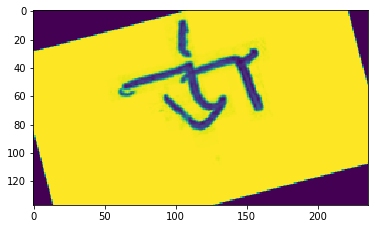

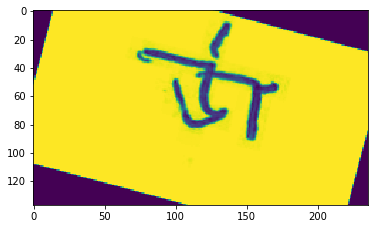

In [0]:
#rotation, left

from skimage.transform import rotate
img = image[rand_num]
img = rotate(img, 15)
plt.imshow(img)
plt.show()

#rotation, right

from skimage.transform import rotate
img = image[rand_num]
img = rotate(img, -15)
plt.imshow(img)
plt.show()

In [0]:
def left(filepath, subset):
  b_train_data = pd.read_parquet(filepath) 
  imageid = b_train_data.iloc[:, 0]
  image = b_train_data.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH)

  size = len(b_train_data) // subset #apply this filter to a subset of the dataframe so the session does not crash
  #create a random list of numbers from which to draw 
  random.seed(34) #set a seed so the same images chosen each time - for debugging
  indices = [np.random.choice(len(b_train_data), replace=False) for i in range(size)]   #print(indices)
    #how can I ensure there's one of each outcome in the frame

  dictionary = dict() #make an empty dictionary

  for i in indices:
    img = image[i]
    img = rotate(img, 15)
    img2 = img.flatten() #make images 1-d again
    dictionary['Train_'+str(i)]=img2
  
  dataframe = pd.DataFrame.from_dict(dictionary, orient='index')
  dataframe.transpose()
  dataframe.columns = dataframe.columns.astype(str)
  dataframe.insert(0, 'image_id', dataframe.index) #make a new image_id column to match other files
  dataframe = dataframe.reset_index() #add a different column of indices, to make it match
  dataframe = dataframe.drop(labels='index', axis=1) #drop superfluous index column
  
  return dataframe

df_left = left(f'bengaliai_cv19/train_image_data_0.parquet', 9)

df_left.head()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-850eebf628e9>", line 29, in <module>
    df_left = left(f'bengaliai_cv19/train_image_data_0.parquet', 9)
  File "<ipython-input-39-850eebf628e9>", line 20, in left
    dataframe = pd.DataFrame.from_dict(dictionary, orient='index')
  File "/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py", line 1205, in from_dict
    return cls(data, index=index, columns=columns, dtype=dtype)
  File "/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py", line 450, in __init__
    arrays, columns = to_arrays(data, columns, dtype=dtype)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    st

KeyboardInterrupt: ignored

In [0]:
#convert to a parquet file
df_left.to_parquet('bengaliai_cv19/train_image_data_5.parquet')

#look at it
df_left_parq = pd.read_parquet('bengaliai_cv19/train_image_data_5.parquet', engine='pyarrow')
df_left_parq.head()

In [0]:
def right(filepath, subset):
  b_train_data = pd.read_parquet(filepath) 
  imageid = b_train_data.iloc[:, 0]
  image = b_train_data.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH)

  size = len(b_train_data) // subset #apply this filter to a subset of the dataframe so the session does not crash
  #create a random list of numbers from which to draw 
  random.seed(12) #set a seed so the same images chosen each time - for debugging
  indices = [np.random.choice(len(b_train_data), replace=False) for i in range(size)]   #print(indices)
    #how can I ensure there's one of each outcome in the frame

  dictionary = dict() #make an empty dictionary

  for i in indices:
    img = image[i]
    img = rotate(img, -15)
    img2 = img.flatten() #make images 1-d again
    dictionary['Train_'+str(i)]=img2
  
  dataframe = pd.DataFrame.from_dict(dictionary, orient='index')
  dataframe.transpose()
  dataframe.columns = dataframe.columns.astype(str)
  dataframe.insert(0, 'image_id', dataframe.index) #make a new image_id column to match other files
  dataframe = dataframe.reset_index() #add a different column of indices, to make it match
  dataframe = dataframe.drop(labels='index', axis=1) #drop superfluous index column
  
  return dataframe

df_right = right(f'bengaliai_cv19/train_image_data_0.parquet', 9)

df_right.head()

In [0]:
#convert to a parquet file
df_right.to_parquet('bengaliai_cv19/train_image_data_6.parquet')

#look at it
df_right_parq = pd.read_parquet('bengaliai_cv19/train_image_data_6.parquet', engine='pyarrow')
df_right_parq.head()

In [0]:
#Change Intensity (Make letters Clear if their intensity is low)

import numpy as np
from skimage import exposure
img = image[rand_num]
v_min, v_max = np.percentile(img, (0.2, 99.8))
img = exposure.rescale_intensity(img, in_range=(v_min, v_max))

plt.imshow(img)
plt.show()


In [0]:
def intense(filepath, subset):
  b_train_data = pd.read_parquet(filepath) 
  imageid = b_train_data.iloc[:, 0]
  image = b_train_data.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH)

  size = len(b_train_data) // subset #apply this filter to a subset of the dataframe so the session does not crash
  #create a random list of numbers from which to draw 
  random.seed(34) #set a seed so the same images chosen each time - for debugging
  indices = [np.random.choice(len(b_train_data), replace=False) for i in range(size)]   #print(indices)
    #how can I ensure there's one of each outcome in the frame

  dictionary = dict() #make an empty dictionary

  for i in indices:
    img = image[i]
    v_min, v_max = np.percentile(img, (0.2, 99.8))
    img = exposure.rescale_intensity(img, in_range=(v_min, v_max))
    img2 = img.flatten() #make images 1-d again
    dictionary['Train_'+str(i)]=img2
  
  dataframe = pd.DataFrame.from_dict(dictionary, orient='index')
  dataframe.transpose()
  dataframe.columns = dataframe.columns.astype(str)
  dataframe.insert(0, 'image_id', dataframe.index) #make a new image_id column to match other files
  dataframe = dataframe.reset_index() #add a different column of indices, to make it match
  dataframe = dataframe.drop(labels='index', axis=1) #drop superfluous index column
  
  return dataframe

df_intense = intense(f'bengaliai_cv19/train_image_data_0.parquet', 12)

df_intense.head()

In [0]:
#convert to a parquet file
df_intense.to_parquet('bengaliai_cv19/train_image_data_7.parquet')

#look at it
df_intense_parq = pd.read_parquet('bengaliai_cv19/train_image_data_7.parquet', engine='pyarrow')
df_intense_parq.head()

# **Keras Tuner**

In [0]:
#importing keras tuner

#You may need to un-comment and run these lines. -L
#!git clone https://github.com/keras-team/keras-tuner.git
#though, since keras-tuner is alredy in the folder, you may simply need to run the following two lines:
%cd keras-tuner
!pip install .
#after installing the keras tuner, you're going to want to switch back to the project directory
%cd /content/drive/My\ Drive/Powerpuff\ Girls
#Keras tuner requries a different version of tensorflow than the rest of the notebook
#it may be necessary to restart the runtime in order to properly run this section

/content/drive/My Drive/Powerpuff Girls/keras-tuner
Processing /content/drive/My Drive/Powerpuff Girls/keras-tuner
  Created wheel for keras-tuner: filename=keras_tuner-1.0.0-cp36-none-any.whl size=86616 sha256=43a52cd0accde3bd10e1b69060b882005173e640b17767ae2ca175ea81bdd921
  Stored in directory: /root/.cache/pip/wheels/ef/f3/02/ff0d4e201e7008ff504fddbf7d3a47b56cde9f2cad504a7ce7
Successfully built keras-tuner
  Found existing installation: keras-tuner 1.0.0
    Uninstalling keras-tuner-1.0.0:
      Successfully uninstalled keras-tuner-1.0.0
/content/drive/My Drive/Powerpuff Girls


In [0]:
#model building for keras tuner
import kerastuner
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

inputs = tf.keras.Input(shape = (IMG_SIZE, IMG_SIZE, 1))
#hp is a variable that allows later uses of keras tuner to use hyperparameters
def build_model(hp):
  inputs = tf.keras.Input(shape = (IMG_SIZE, IMG_SIZE, 1))
  model = Conv2D(filters=hp.Int('filters', min_value = 16, max_value = 128, step = 16),
                 kernel_size=(3,3),
                 padding='SAME', 
                 activation='relu', 
                 input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
  for i in range(4):
    for i in range(3):
      model = Conv2D(filters=hp.Int('filters', min_value = 32, max_value = 128, step = 16),
                     kernel_size=(3,3),
                     padding='SAME',
                     activation='relu')(model)
    model = BatchNormalization(momentum=0.15)(model)
    model = MaxPool2D(pool_size=(2,2))(model)
    model = Conv2D(filters= hp.Int('filters', min_value = 64, max_value = 256, step = 16), 
                   kernel_size=(5,5),
                   padding='SAME',
                   activation='relu')(model)
    model = Dropout(rate=0.3)(model)

  model = Flatten()(model)
  #model = GlobalAveragePooling2D(data_format='channels_last')(model)
  model = Dense(1024, activation = "relu")(model)
  model = Dropout(rate=0.3)(model)

  dense = Dense(512, activation = "relu")(model)
  head_root = Dense(168, activation = 'softmax')(dense)
  head_vowel = Dense(11, activation = 'softmax')(dense)
  head_consonant = Dense(7, activation = 'softmax')(dense)

  model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [0]:
#the strings here are modified from above to be compatible with the tuner
learning_rate_reduction_root = ReduceLROnPlateau(monitor='val_dense_2_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='val_dense_3_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='val_dense_4_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
tf.__version__

'2.2.0-rc0'

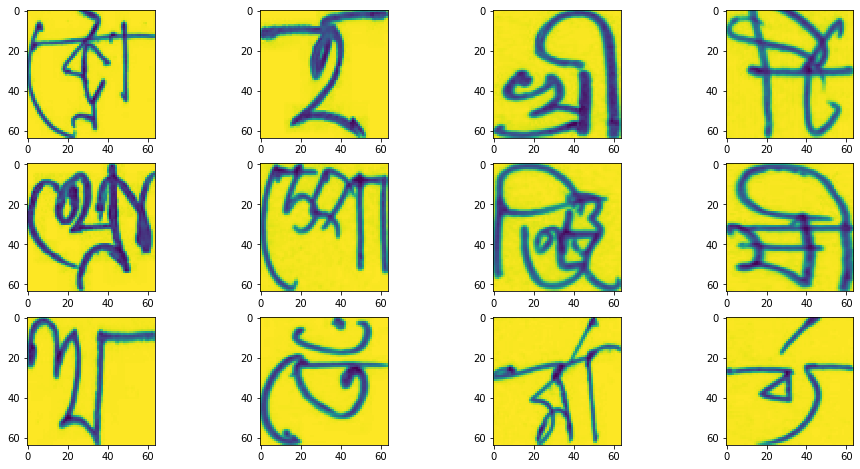


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
INFO:tensorflow:Reloading Oracle from existing project ./test_tuner_ver2/oracle.json


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 66, in _get_default_graph
    return tf.get_default_graph()
AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-42-0ef208c5edb9>", line 14, in build_model
    input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
  File "/usr/local/lib/python3.6/dist-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/layers/convolutional.py", line 484, in __init__
    **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/layers/convolutional.py", line 105, in __init__
    super(_Conv, self).__init__(**kwarg

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 66, in _get_default_graph
    return tf.get_default_graph()
AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-42-0ef208c5edb9>", line 14, in build_model
    input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
  File "/usr/local/lib/python3.6/dist-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/layers/convolutional.py", line 484, in __init__
    **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/layers/convolutional.py", line 105, in __init__
    super(_Conv, self).__init__(**kwarg

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 66, in _get_default_graph
    return tf.get_default_graph()
AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-42-0ef208c5edb9>", line 14, in build_model
    input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
  File "/usr/local/lib/python3.6/dist-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/layers/convolutional.py", line 484, in __init__
    **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/layers/convolutional.py", line 105, in __init__
    super(_Conv, self).__init__(**kwarg

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 66, in _get_default_graph
    return tf.get_default_graph()
AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-42-0ef208c5edb9>", line 14, in build_model
    input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
  File "/usr/local/lib/python3.6/dist-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/layers/convolutional.py", line 484, in __init__
    **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/layers/convolutional.py", line 105, in __init__
    super(_Conv, self).__init__(**kwarg

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 66, in _get_default_graph
    return tf.get_default_graph()
AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-42-0ef208c5edb9>", line 14, in build_model
    input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
  File "/usr/local/lib/python3.6/dist-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/layers/convolutional.py", line 484, in __init__
    **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/layers/convolutional.py", line 105, in __init__
    super(_Conv, self).__init__(**kwarg

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 66, in _get_default_graph
    return tf.get_default_graph()
AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-42-0ef208c5edb9>", line 14, in build_model
    input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
  File "/usr/local/lib/python3.6/dist-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/layers/convolutional.py", line 484, in __init__
    **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/layers/convolutional.py", line 105, in __init__
    super(_Conv, self).__init__(**kwarg

RuntimeError: ignored

In [0]:
#The keras-tuner version of the training loop

histories = []
#something different: the kerastuner objective, so we don't need to mess around with the loop every time.
obj = kerastuner.Objective('val_dense_4_accuracy', direction = 'max')

for i in range(2):
    train_df = pd.merge(pd.read_parquet(f'bengaliai_cv19/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)
    #print(train_df.head())
    # Visualize few samples of current training dataset
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
    count=0
    for row in ax:
        for col in row:
            col.imshow(resize(train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], need_progress_bar=False).values.reshape(-1).reshape(IMG_SIZE, IMG_SIZE).astype(np.float64))
            count += 1
    plt.show()
    
    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train)/255
    
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')

    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)

    #alright, so for the keras tuner steps
    #here's where things really start to get different:

    #use the tuner to fit the best models
    tuner = RandomSearch(
        build_model,
        objective = obj,
        max_trials = 5,
        executions_per_trial = 1,
        project_name = 'test_tuner_ver2'
    )
    history = tuner.search(x_train, {'dense_2': y_train_root, 'dense_3': y_train_vowel, 'dense_4': y_train_consonant},
                           epochs = 1, validation_data=(x_test, [y_test_root, y_test_vowel, y_test_consonant]),
                           callbacks=[keras.callbacks.TensorBoard(),learning_rate_reduction_root, 
                                      learning_rate_reduction_vowel, learning_rate_reduction_consonant])


    log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    histories.append(history)
    models = tuner.get_best_models(num_models=2)
    print("result summary:")
    tuner.results_summary()
    print(f"best model for loop{i}:\n")
    print(models[0].evaluate(x_test, [y_test_root, y_test_vowel, y_test_consonant]))
    
    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()



In [0]:
models = tuner.get_best_models(num_models=2)
tuner.results_summary()